In [1]:
from core import *

import glob
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

from skimage.morphology import erosion, dilation, disk

from config import figures_dir, drive_dir

# loading the list of files
files= glob.glob(os.path.join(drive_dir, '*', '*', '*'))

# splitting the training and test images
training= [f for f in files if 'training' in f]
test= [f for f in files if 'test' in f]

# splitting images, fov masks and manual segmentations

training_img= [f for f in training if 'images' in f]
training_mask= [f for f in training if 'mask' in f]
training_manual= [f for f in training if 'manual' in f]

test_img= [f for f in test if 'images' in f]
test_mask= [f for f in test if 'mask' in f]
test_manual1= [f for f in test if 'manual1' in f]
test_manual2= [f for f in test if 'manual2' in f]

In [2]:
results= []

baseline= {}
baseline_all= {}

selem = disk(1)

for img in test_img:
    # calculating basic statistics and performance scores for the test images
    identifier= img.split(os.sep)[-1].split('_')[0]
    mask= [f for f in test_mask if identifier in f][0]
    manual1= [f for f in test_manual1 if identifier in f][0]

    mask= np.array(Image.open(mask))
    manual1= np.array(Image.open(manual1))

    p_fov= np.sum(np.logical_and(manual1 > 0, mask > 0))
    n_fov= np.sum(np.logical_and(manual1 == 0, mask > 0))

    baseline[identifier]= [p_fov, n_fov]

    p_fov= np.sum(manual1 > 0)
    n_fov= np.sum(manual1 == 0)

    baseline_all[identifier]= [p_fov, n_fov]

orig_fov_fractions= []

for img in test_img:
    print('processing %s' % img)
    # calculating basic statistics and performance scores for the test images
    identifier= img.split(os.sep)[-1].split('_')[0]
    mask_name= [f for f in test_mask if identifier in f][0]
    manual1= [f for f in test_manual1 if identifier in f][0]
    manual2= [f for f in test_manual2 if identifier in f][0]

    mask= Image.open(mask_name)
    manual1= np.array(Image.open(manual1))
    manual2= np.array(Image.open(manual2))

    radius= 0
    # dilating the FoV
    for k in range(1, 200):
        if radius != 0:
            mask= dilation(np.array(mask), selem)
            if identifier == '01' and radius == 60:
                plt.imsave(os.path.join(figures_dir, '01-fov-60.pdf'), mask, cmap=plt.get_cmap('gray'))
        else:
            mask= np.array(mask)
            orig_fov_fractions.append(np.round(np.sum(mask > 0)/np.prod(mask.shape), 3))
            if identifier == '01' and radius == 60:
                plt.imsave(os.path.join(figures_dir, '01-fov-0.pdf'), mask, cmap=plt.get_cmap('gray'))
        
        # manual1 being the ground truth, treating manual2 as a segmentation, using FOV
        tp= np.sum(np.logical_and(np.logical_and(manual1 > 0, manual2 > 0), mask > 0))
        fp= np.sum(np.logical_and(np.logical_and(manual1 == 0, manual2 > 0), mask > 0))
        tn= np.sum(np.logical_and(np.logical_and(manual1 == 0, manual2 == 0), mask > 0))
        fn= np.sum(np.logical_and(np.logical_and(manual1 > 0, manual2 == 0), mask > 0))

        p_fov= tp + fn
        n_fov= tn + fp

        acc= (tp + tn)/(tp + tn + fp + fn)
        spec= tn/(n_fov)
        sens= tp/p_fov
        
        for digits in [3, 4]:
            eps= 10**(-digits)
            perc= np.round(np.sum(mask > 0)/np.prod(mask.shape), 2)
            if radius == 0:
                perc= 0.687
            if np.abs(perc - 0.687) < 0.01:
                pass
            results.append([radius, identifier, consistency_image_level(baseline[identifier][0], baseline[identifier][1], np.round(acc, digits), np.round(sens, digits), np.round(spec, digits), eps), digits, acc, spec, sens, 'official FoV', perc])
        
        for digits in [3, 4]:
            eps= 10**(-digits)
            perc= np.round(np.sum(mask > 0)/np.prod(mask.shape), 2)
            if radius == 0:
                perc= 0.68
            if np.abs(perc - 0.687) < 0.01:
                pass
            results.append([radius, identifier, consistency_image_level(baseline_all[identifier][0], baseline_all[identifier][1], np.round(acc, digits), np.round(sens, digits), np.round(spec, digits), eps), digits, acc, spec, sens, 'all pixels', perc])
        
        radius= radius + 1

        if np.sum(mask > 0) == np.prod(mask.shape):
            break

    mask= np.array(Image.open(mask_name))
    radius= 0
    # eroding the FoV
    for _ in range(1, 50):
        radius= radius - 1

        mask= erosion(mask, selem)

        if identifier == '01' and radius == -60:
            plt.imsave(os.path.join(figures_dir, '01-fov--60.pdf'), mask, cmap=plt.get_cmap('gray'))

        # manual1 being the ground truth, treating manual2 as a segmentation, using FOV
        tp= np.sum(np.logical_and(np.logical_and(manual1 > 0, manual2 > 0), mask > 0))
        fp= np.sum(np.logical_and(np.logical_and(manual1 == 0, manual2 > 0), mask > 0))
        tn= np.sum(np.logical_and(np.logical_and(manual1 == 0, manual2 == 0), mask > 0))
        fn= np.sum(np.logical_and(np.logical_and(manual1 > 0, manual2 == 0), mask > 0))

        p_fov= tp + fn
        n_fov= tn + fp

        acc= (tp + tn)/(tp + tn + fp + fn)
        spec= tn/(n_fov)
        sens= tp/p_fov
        
        for digits in [3, 4]:
            eps= 10**(-digits)
            results.append([radius, identifier, consistency_image_level(baseline[identifier][0], baseline[identifier][1], np.round(acc, digits), np.round(sens, digits), np.round(spec, digits), eps), digits, acc, spec, sens, 'official FoV', np.round(np.sum(mask > 0)/np.prod(mask.shape), 2)])
        
        for digits in [3, 4]:
            eps= 10**(-digits)
            results.append([radius, identifier, consistency_image_level(baseline_all[identifier][0], baseline_all[identifier][1], np.round(acc, digits), np.round(sens, digits), np.round(spec, digits), eps), digits, acc, spec, sens, 'all pixels', np.round(np.sum(mask > 0)/np.prod(mask.shape), 2)])

print(np.mean(orig_fov_fractions))

processing data/drive/test/images/07_test.tif
processing data/drive/test/images/02_test.tif
processing data/drive/test/images/19_test.tif
processing data/drive/test/images/10_test.tif
processing data/drive/test/images/12_test.tif
processing data/drive/test/images/09_test.tif
processing data/drive/test/images/14_test.tif
processing data/drive/test/images/04_test.tif
processing data/drive/test/images/06_test.tif
processing data/drive/test/images/16_test.tif
processing data/drive/test/images/08_test.tif
processing data/drive/test/images/20_test.tif
processing data/drive/test/images/17_test.tif
processing data/drive/test/images/11_test.tif
processing data/drive/test/images/13_test.tif
processing data/drive/test/images/03_test.tif
processing data/drive/test/images/05_test.tif
processing data/drive/test/images/01_test.tif
processing data/drive/test/images/18_test.tif
processing data/drive/test/images/15_test.tif
0.6876499999999999


In [3]:
# constructing the image statistics dataframe
radius_stats= pd.DataFrame(results, columns= ['radius', 'identifier', 'consistency', 'digits', 'acc', 'spec', 'sens', 'FoV', 'percentage'])

In [4]:
grouped= radius_stats.groupby(['percentage', 'digits', 'FoV']).mean().reset_index(drop=False)

In [5]:
grouped[grouped['FoV'] == 'FoV']

,percentage,digits,FoV,radius,consistency,acc,spec,sens


In [6]:
#grouped.loc[grouped['FoV'] == 'all pixels', 'radius']= grouped.loc[grouped['FoV'] == 'all pixels', 'radius'] + 150

In [7]:
grouped[grouped['digits'] == 3]

,percentage,digits,FoV,radius,consistency,acc,spec,sens
0,0.47,3,all pixels,-48.857143,0.000000,0.944445,0.974499,0.759717
1,0.47,3,official FoV,-48.857143,0.285714,0.944445,0.974499,0.759717
4,0.48,3,all pixels,-48.047619,0.000000,0.943413,0.970216,0.777753
5,0.48,3,official FoV,-48.047619,0.500000,0.943413,0.970216,0.777753
8,0.49,3,all pixels,-45.637931,0.000000,0.943595,0.969805,0.781480
...,...,...,...,...,...,...,...,...
207,0.98,3,official FoV,133.532203,0.000000,0.962952,0.981475,0.775573
210,0.99,3,all pixels,151.541176,1.000000,0.963337,0.981726,0.775491
211,0.99,3,official FoV,151.541176,0.000000,0.963337,0.981726,0.775491
214,1.00,3,all pixels,179.987395,1.000000,0.963662,0.981825,0.776025


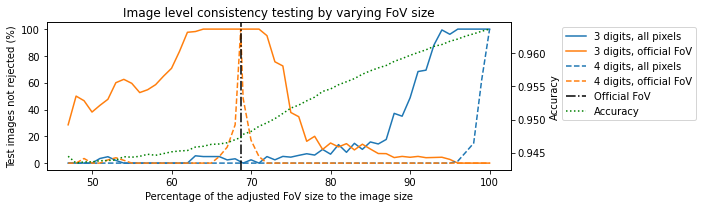

In [8]:
linestyles=['-', '--', '-.', ':']
colors= ['#1f77b4', '#ff7f0e']

fig= plt.figure(figsize=(10, 3))
ax= fig.add_subplot(111)

plots= []

for i, d in enumerate(np.unique(grouped['digits'])):
    for j, p in enumerate(np.unique(grouped['FoV'])):
        series= grouped[(grouped['digits'] == d) & (grouped['FoV'] == p)]
        plots.append(ax.plot(series['percentage']*100, series['consistency']*100, label=', '.join([str(d) + ' digits', str(p)]), ls=linestyles[i], c=colors[j]))

plots.append([ax.axvline(0.687*100, label='Official FoV', color='black', ls='-.')])
ax1= ax.twinx()

overall_means= grouped.groupby(['percentage']).agg({'acc': 'mean'})
overall_means= overall_means.reset_index(drop=False)

ax.set_ylabel('Test images not rejected (%)')

plots.append(ax1.plot(overall_means['percentage']*100, overall_means['acc'], color='green', label='Accuracy', ls=':'))
ax1.set_ylabel('Accuracy')

ax.set_xlabel('Percentage of the adjusted FoV size to the image size')

plt.title('Image level consistency testing by varying FoV size')
lns= plots[0]
for p in plots[1:]:
    lns= lns + p
labs= [l[0].get_label() for l in plots]
ax.legend(lns, labs, bbox_to_anchor=(1.1, 1), loc='upper left')

plt.tight_layout()

plt.savefig(os.path.join(figures_dir, 'sensitivity.pdf'))
plt.show()



## Aggregated

In [9]:
results= []

p_fovs= [None]*20
n_fovs= [None]*20

p_alls= [None]*20
n_alls= [None]*20

for img in test_img:
    # calculating basic statistics and performance scores for the test images
    identifier= img.split(os.sep)[-1].split('_')[0]
    mask= [f for f in test_mask if identifier in f][0]
    manual1= [f for f in test_manual1 if identifier in f][0]
    manual2= [f for f in test_manual2 if identifier in f][0]

    mask= np.array(Image.open(mask))
    manual1= np.array(Image.open(manual1))
    manual2= np.array(Image.open(manual2))

    p_fov= np.sum(np.logical_and(manual1 > 0, mask > 0))
    n_fov= np.sum(np.logical_and(manual1 == 0, mask > 0))
    size_fov= np.sum(mask > 0)

    p_fovs[int(identifier)-1]= p_fov
    n_fovs[int(identifier)-1]= n_fov

    p_all= np.sum(manual1 > 0)
    n_all= np.sum(manual1 == 0)

    p_alls[int(identifier)-1]= p_all
    n_alls[int(identifier)-1]= n_all

test_masks= [None]*20
test_manual1s= [None]*20
test_manual2s= [None]*20

for img in test_img:
    print('processing %s' % img)
    # calculating basic statistics and performance scores for the test images
    identifier= img.split(os.sep)[-1].split('_')[0]
    mask_name= [f for f in test_mask if identifier in f][0]
    manual1= [f for f in test_manual1 if identifier in f][0]
    manual2= [f for f in test_manual2 if identifier in f][0]

    mask= np.array(Image.open(mask_name))
    manual1= np.array(Image.open(manual1))
    manual2= np.array(Image.open(manual2))

    test_masks[int(identifier)-1]= mask
    test_manual1s[int(identifier)-1]= manual1
    test_manual2s[int(identifier)-1]= manual2

radius= 0
for _ in range(1, 200):
    print('radius', radius)
    if radius != 0:
        for i in range(len(test_masks)):
            test_masks[i]= dilation(np.array(test_masks[i]), selem)
    else:
        pass
    test_accs= []
    test_senss= []
    test_specs= []

    for i in range(len(test_masks)):
        tp= np.sum(np.logical_and(np.logical_and(test_manual1s[i] > 0, test_manual2s[i] > 0), test_masks[i] > 0))
        fp= np.sum(np.logical_and(np.logical_and(test_manual1s[i] == 0, test_manual2s[i] > 0), test_masks[i] > 0))
        tn= np.sum(np.logical_and(np.logical_and(test_manual1s[i] == 0, test_manual2s[i] == 0), test_masks[i] > 0))
        fn= np.sum(np.logical_and(np.logical_and(test_manual1s[i] > 0, test_manual2s[i] == 0), test_masks[i] > 0))

        test_accs.append((tp + tn)/(tp + tn + fp + fn))
        test_specs.append(tn/(tn + fp))
        test_senss.append(tp/(tp + fn))
        
    for digits in [3, 4]:
        eps= 10**(-digits)
        results.append([radius, identifier, consistency_aggregated(np.array(p_fovs), np.array(n_fovs), np.round(np.mean(test_accs), digits), np.round(np.mean(test_senss), digits), np.round(np.mean(test_specs), digits), eps), digits, np.mean(test_accs), np.mean(test_specs), np.mean(test_senss), 'official FoV', np.round(np.sum(test_masks[0] > 0)/np.prod(test_masks[0].shape), 3)])
    
    for digits in [3, 4]:
        eps= 10**(-digits)
        results.append([radius, identifier, consistency_aggregated(np.array(p_alls), np.array(n_alls), np.round(np.mean(test_accs), digits), np.round(np.mean(test_senss), digits), np.round(np.mean(test_specs), digits), eps), digits, np.mean(test_accs), np.mean(test_specs), np.mean(test_senss), 'all pixels', np.round(np.sum(test_masks[0] > 0)/np.prod(test_masks[0].shape), 3)])
    
    radius= radius + 3

for img in test_img:
    print('processing %s' % img)
    # calculating basic statistics and performance scores for the test images
    identifier= img.split(os.sep)[-1].split('_')[0]
    mask_name= [f for f in test_mask if identifier in f][0]
    manual1= [f for f in test_manual1 if identifier in f][0]
    manual2= [f for f in test_manual2 if identifier in f][0]

    mask= np.array(Image.open(mask_name))
    manual1= np.array(Image.open(manual1))
    manual2= np.array(Image.open(manual2))

    test_masks[int(identifier)-1]= mask
    test_manual1s[int(identifier)-1]= manual1
    test_manual2s[int(identifier)-1]= manual2

radius= 0
for _ in range(1, 50):
    radius= radius - 3
    print('radius', radius)
    if radius != 0:
        for i in range(len(test_masks)):
            test_masks[i]= erosion(np.array(test_masks[i]), selem)
    else:
        pass
    test_accs= []
    test_senss= []
    test_specs= []

    for i in range(len(test_masks)):
        tp= np.sum(np.logical_and(np.logical_and(test_manual1s[i] > 0, test_manual2s[i] > 0), test_masks[i] > 0))
        fp= np.sum(np.logical_and(np.logical_and(test_manual1s[i] == 0, test_manual2s[i] > 0), test_masks[i] > 0))
        tn= np.sum(np.logical_and(np.logical_and(test_manual1s[i] == 0, test_manual2s[i] == 0), test_masks[i] > 0))
        fn= np.sum(np.logical_and(np.logical_and(test_manual1s[i] > 0, test_manual2s[i] == 0), test_masks[i] > 0))

        test_accs.append((tp + tn)/(tp + tn + fp + fn))
        test_specs.append(tn/(tn + fp))
        test_senss.append(tp/(tp + fn))
        
    for digits in [3, 4]:
        eps= 10**(-digits)
        results.append([radius, identifier, consistency_aggregated(np.array(p_fovs), np.array(n_fovs), np.round(np.mean(test_accs), digits), np.round(np.mean(test_senss), digits), np.round(np.mean(test_specs), digits), eps), digits, np.mean(test_accs), np.mean(test_specs), np.mean(test_senss), 'official FoV', np.round(np.sum(test_masks[0] > 0)/np.prod(test_masks[0].shape), 3)])
    
    for digits in [3, 4]:
        eps= 10**(-digits)
        results.append([radius, identifier, consistency_aggregated(np.array(p_alls), np.array(n_alls), np.round(np.mean(test_accs), digits), np.round(np.mean(test_senss), digits), np.round(np.mean(test_specs), digits), eps), digits, np.mean(test_accs), np.mean(test_specs), np.mean(test_senss), 'all pixels', np.round(np.sum(test_masks[0] > 0)/np.prod(test_masks[0].shape), 3)])


processing data/drive/test/images/07_test.tif
processing data/drive/test/images/02_test.tif
processing data/drive/test/images/19_test.tif
processing data/drive/test/images/10_test.tif
processing data/drive/test/images/12_test.tif
processing data/drive/test/images/09_test.tif
processing data/drive/test/images/14_test.tif
processing data/drive/test/images/04_test.tif
processing data/drive/test/images/06_test.tif
processing data/drive/test/images/16_test.tif
processing data/drive/test/images/08_test.tif
processing data/drive/test/images/20_test.tif
processing data/drive/test/images/17_test.tif
processing data/drive/test/images/11_test.tif
processing data/drive/test/images/13_test.tif
processing data/drive/test/images/03_test.tif
processing data/drive/test/images/05_test.tif
processing data/drive/test/images/01_test.tif
processing data/drive/test/images/18_test.tif
processing data/drive/test/images/15_test.tif
radius 0
radius 3
radius 6
radius 9
radius 12
radius 15
radius 18
radius 21
radi

In [10]:
# constructing the image statistics dataframe
radius_stats= pd.DataFrame(results, columns= ['radius', 'identifier', 'consistency', 'digits', 'acc', 'spec', 'sens', 'FoV', 'percentage'])

In [11]:
grouped= radius_stats.groupby(['percentage', 'digits', 'FoV']).mean().reset_index(drop=False)

In [12]:
grouped

,percentage,digits,FoV,radius,consistency,acc,spec,sens
0,0.470,3,all pixels,-147.0,False,0.943463,0.969970,0.778832
1,0.470,3,official FoV,-147.0,True,0.943463,0.969970,0.778832
2,0.470,4,all pixels,-147.0,False,0.943463,0.969970,0.778832
3,0.470,4,official FoV,-147.0,True,0.943463,0.969970,0.778832
4,0.474,3,all pixels,-144.0,False,0.943483,0.969976,0.779279
...,...,...,...,...,...,...,...,...
799,0.999,4,official FoV,547.5,False,0.963679,0.981884,0.775673
800,1.000,3,all pixels,577.5,True,0.963699,0.981895,0.775673
801,1.000,3,official FoV,577.5,False,0.963699,0.981895,0.775673
802,1.000,4,all pixels,577.5,True,0.963699,0.981895,0.775673


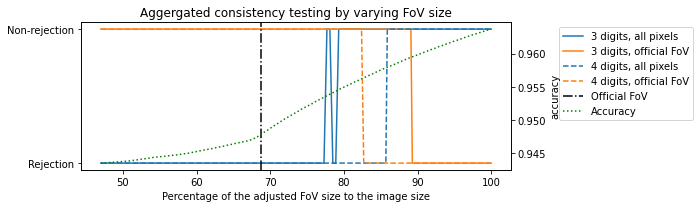

In [13]:
linestyles=['-', '--', '-.', ':']
colors= ['#1f77b4', '#ff7f0e']

fig= plt.figure(figsize=(10, 3))
ax= fig.add_subplot(111)

plots= []

for i, d in enumerate(np.unique(grouped['digits'])):
    for j, p in enumerate(np.unique(grouped['FoV'])):
        series= grouped[(grouped['digits'] == d) & (grouped['FoV'] == p)]
        plots.append(ax.plot(series['percentage']*100, series['consistency'], label=', '.join([str(d) + ' digits', str(p)]), ls=linestyles[i], c=colors[j]))

plots.append([ax.axvline(0.687*100, label='Official FoV', color='black', ls='-.')])
ax1= ax.twinx()

overall_means= grouped.groupby(['percentage']).agg({'acc': 'mean'})
overall_means= overall_means.reset_index(drop=False)

#ax.set_ylabel('percentage of scores passing')

plots.append(ax1.plot(overall_means['percentage']*100, overall_means['acc'], color='green', label='Accuracy', ls=':'))
ax1.set_ylabel('accuracy')


ax.set_xlabel('Percentage of the adjusted FoV size to the image size')

plt.title('Aggergated consistency testing by varying FoV size')
lns= plots[0]
for p in plots[1:]:
    lns= lns + p
labs= [l[0].get_label() for l in plots]
ax.legend(lns, labs, bbox_to_anchor=(1.1, 1), loc='upper left')

ax.set_yticks([0, 1])
ax.set_yticklabels(['Rejection', 'Non-rejection'])

plt.tight_layout()

plt.savefig(os.path.join(figures_dir, 'sensitivity-agg.pdf'))
plt.show()

